# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Do-we-even-need-a-smart-learning-algorithm?-Is-UCB-useless?" data-toc-modified-id="Do-we-even-need-a-smart-learning-algorithm?-Is-UCB-useless?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><em>Do we even need a smart learning algorithm? Is UCB useless?</em></a></div><div class="lev2 toc-item"><a href="#Notations-for-the-arms" data-toc-modified-id="Notations-for-the-arms-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Notations for the arms</a></div><div class="lev2 toc-item"><a href="#Importing-the-algorithms" data-toc-modified-id="Importing-the-algorithms-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Importing the algorithms</a></div><div class="lev2 toc-item"><a href="#The-UCB-algorithm" data-toc-modified-id="The-UCB-algorithm-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>The <code>UCB</code> algorithm</a></div><div class="lev2 toc-item"><a href="#The-EmpiricalMeans-algorithm" data-toc-modified-id="The-EmpiricalMeans-algorithm-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>The <code>EmpiricalMeans</code> algorithm</a></div><div class="lev2 toc-item"><a href="#Creating-some-MAB-problems" data-toc-modified-id="Creating-some-MAB-problems-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Creating some MAB problems</a></div><div class="lev3 toc-item"><a href="#Parameters-for-the-simulation" data-toc-modified-id="Parameters-for-the-simulation-151"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Parameters for the simulation</a></div><div class="lev3 toc-item"><a href="#Some-MAB-problem-with-Bernoulli-arms" data-toc-modified-id="Some-MAB-problem-with-Bernoulli-arms-152"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Some MAB problem with Bernoulli arms</a></div><div class="lev3 toc-item"><a href="#Some-RL-algorithms" data-toc-modified-id="Some-RL-algorithms-153"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Some RL algorithms</a></div><div class="lev2 toc-item"><a href="#Creating-the-Evaluator-object" data-toc-modified-id="Creating-the-Evaluator-object-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Creating the <code>Evaluator</code> object</a></div><div class="lev2 toc-item"><a href="#Solving-the-problem" data-toc-modified-id="Solving-the-problem-17"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Solving the problem</a></div><div class="lev2 toc-item"><a href="#Plotting-the-results" data-toc-modified-id="Plotting-the-results-18"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Plotting the results</a></div><div class="lev3 toc-item"><a href="#First-problem" data-toc-modified-id="First-problem-181"><span class="toc-item-num">1.8.1&nbsp;&nbsp;</span>First problem</a></div><div class="lev3 toc-item"><a href="#Second-problem" data-toc-modified-id="Second-problem-182"><span class="toc-item-num">1.8.2&nbsp;&nbsp;</span>Second problem</a></div><div class="lev3 toc-item"><a href="#Third-problem" data-toc-modified-id="Third-problem-183"><span class="toc-item-num">1.8.3&nbsp;&nbsp;</span>Third problem</a></div><div class="lev2 toc-item"><a href="#Conclusion" data-toc-modified-id="Conclusion-19"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Conclusion</a></div>

# *Do we even need a smart learning algorithm? Is UCB useless?*

This short notebook demonstrates that "smart" Multi-Armed Bandits learning algorithms, like UCB, are indeed needed to learn the distribution of arms, even in the simplest case.

We will use an example of a small Single-Player simulation, and compare the `UCB` algorithm with a naive "max empirical reward" algorithm.
The goal is to illustrate that introducing an exploration term (the confidence width), like what is done in UCB and similar algorithms, really helps learning and improves performance.

----

## Notations for the arms

To remind the usual notations, there is a fixed number $K \geq 1$ of levers, or "arms", and a player has to select one lever at each discrete times $t \geq 1, t \in \mathbb{N}$, ie $k = A(t)$. Selecting an arm $k$ at time $t$ will yield a (random) *reward*, $r_k(t)$, and the goal of the player is to maximize its cumulative reward $R_T = \sum_{t = 1}^T r_{A(t)}(t)$.

Each arm is associated with a distribution $\nu_k$, for $k = 1,\dots,K$, and the usual restriction is to consider one-dimensional exponential family (it includes Gaussian, Exponential and Bernoulli distributions), ie distributions parametered by their means, $\mu_k$.
So the arm $k$, $r_k(t) \sim \nu_k$, are iid, and assumed bounded in $[a,b] = [0,1]$.

For instance, arms can follow Bernoulli distributions, of means $\mu_1,\dots,\mu_K \in [0,1]$: $r_k(t) \sim \mathrm{Bern}(\mu_k)$, ie $\mathbb{P}(r_k(t) = 1) = \mu_k$.

Let $N_k(t) = \sum_{\tau=1}^t \mathbb{1}(A(t) = k)$ be the number of times arm $k$ was selected up-to time $t \geq 1$.
The empirical mean of arm $k$ is then defined as $\hat{\mu_k}(t) := \frac{\sum_{\tau=1}^t \mathbb{1}(A(t) = k) r_k(t) }{N_k(t)}$.

----

## Importing the algorithms

First, be sure to be in the main folder, and import `Evaluator` from `Environment` package:

In [1]:
from sys import path
path.insert(0, '..')

In [3]:
# Local imports
from Environment import Evaluator, tqdm

We also need arms, for instance `Bernoulli`-distributed arm:

In [7]:
# Import arms
from Arms import Bernoulli

And finally we need some single-player Reinforcement Learning algorithms.
I focus here on the `UCB` index policy, and the base class `IndexPolicy` will be used to easily define another algorithm.

In [9]:
# Import algorithms
from Policies import UCB, UCBalpha
from Policies.IndexPolicy import IndexPolicy

---

## The `UCB` algorithm

First, we can check the documentation of the `UCB` class, implementing the **Upper-Confidence Bounds algorithm**.

In [13]:
# Just improving the ?? in Jupyter. Thanks to https://nbviewer.jupyter.org/gist/minrk/7715212
from __future__ import print_function
from IPython.core import page
def myprint(s):
    try:
        print(s['text/plain'])
    except (KeyError, TypeError):
        print(s)
page.page = myprint

In [14]:
UCB?

Init signature: UCB(nbArms, lower=0.0, amplitude=1.0)
Docstring:     
The UCB policy for bounded bandits.
Reference: [Lai & Robbins, 1985].
Init docstring:
New generic index policy.

- nbArms: the number of arms,
- lower, amplitude: lower value and known amplitude of the rewards.
File:           ~/SMPyBandits.git/Policies/UCB.py
Type:           type



Let us quickly have a look to the code of the `UCB` policy imported above.

In [15]:
UCB??

Init signature: UCB(nbArms, lower=0.0, amplitude=1.0)
Source:        
class UCB(IndexPolicy):
    """ The UCB policy for bounded bandits.
    Reference: [Lai & Robbins, 1985].
    """

    def computeIndex(self, arm):
        r""" Compute the current index, at time t and after :math:`N_k(t)` pulls of arm k:

        .. math:: I_k(t) = \frac{X_k(t)}{N_k(t)} + \sqrt{\frac{2 \log(t)}{N_k(t)}}.
        """
        if self.pulls[arm] < 1:
            return float('+inf')
        else:
            return (self.rewards[arm] / self.pulls[arm]) + sqrt((2 * log(self.t)) / self.pulls[arm])

    def computeAllIndex(self):
        """ Compute the current indexes for all arms, in a vectorized manner."""
        indexes = (self.rewards / self.pulls) + np.sqrt((2 * np.log(self.t)) / self.pulls)
        indexes[self.pulls < 1] = float('+inf')
        self.index = indexes
File:           ~/SMPyBandits.git/Policies/UCB.py
Type:           type



This policy is defined by inheriting from `IndexPolicy`, which is a generic class already implementing all the methods (`choice()` to get $A(t) \in \{1,\dots,K\}$, etc).
The only method defined in this class is the `computeIndex(arm)` method, which here uses a UCB index: the empirical mean plus a confidence width term (hence the name "upper confidence bound").

For the classical `UCB` algorithm, with $\alpha=4$, the index is computed in two parts:

- the empirical mean: $\hat{\mu}_k(t) := \frac{\sum_{\tau=1}^t \mathbb{1}(A(t) = k) r_k(t) }{N_k(t)}$, computed as `rewards[k] / pulls[k]` in the code,
- the upper confidence bound, $B_k(t) := \sqrt{\frac{\alpha \log(t)}{2 N_k(t)}}$, computed as `sqrt((2 * log(t)) / pulls[k]` in the code.

Then the index $X_k(t) = \hat{\mu}_k(t) + B_k(t)$ is used to decide which arm to select at time $t+1$:
$$ A(t+1) = \arg\max_k X_k(t). $$

The simple `UCB1` algorithm uses $\alpha = 4$, but empirically $\alpha = 1$ is known to work better.

## The `EmpiricalMeans` algorithm

We can write a new bandit algorithm quite easily with my framework.
For simple index-based policy, we simply need to write a `computeIndex(arm)` method, as presented above.

The `EmpiricalMeans` algorithm will be simpler than `UCB`, as the decision will only be based on the empirical means $\hat{\mu}_k(t)$:
$$ A(t+1) = \arg\max_k \hat{\mu}_k(t). $$

In [16]:
IndexPolicy?

Init signature: IndexPolicy(nbArms, lower=0.0, amplitude=1.0)
Docstring:      Class that implements a generic index policy.
Init docstring:
New generic index policy.

- nbArms: the number of arms,
- lower, amplitude: lower value and known amplitude of the rewards.
File:           ~/SMPyBandits.git/Policies/IndexPolicy.py
Type:           type



Inheriting from this class makes the job easier:

In [17]:
class EmpiricalMeans(IndexPolicy):
    """ The naive Empirical Means policy for bounded bandits."""

    def computeIndex(self, arm):
        if self.pulls[arm] < 2:
            return float('+inf')
        else:
            return self.rewards[arm] / self.pulls[arm]

In [18]:
EmpiricalMeans?

Init signature: EmpiricalMeans(nbArms, lower=0.0, amplitude=1.0)
Docstring:      The naive Empirical Means policy for bounded bandits.
Init docstring:
New generic index policy.

- nbArms: the number of arms,
- lower, amplitude: lower value and known amplitude of the rewards.
Type:           type



----

## Creating some MAB problems

### Parameters for the simulation

- $T = 10000$ is the time horizon,
- $N = 100$ is the number of repetitions,
- `N_JOBS = 4` is the number of cores used to parallelize the code.

In [9]:
HORIZON = 10000
REPETITIONS = 100
N_JOBS = 4

### Some MAB problem with Bernoulli arms

We consider in this example $3$ problems, with `Bernoulli` arms, of different means.

In [10]:
ENVIRONMENTS = [  # 1)  Bernoulli arms
        {   # A very easy problem, but it is used in a lot of articles
            "arm_type": Bernoulli,
            "params": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        },
        {   # An other problem, best arm = last, with three groups: very bad arms (0.01, 0.02), middle arms (0.3 - 0.6) and very good arms (0.78, 0.8, 0.82)
            "arm_type": Bernoulli,
            "params": [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]
        },
        {   # A very hard problem, as used in [Cappé et al, 2012]
            "arm_type": Bernoulli,
            "params": [0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.05, 0.1]
        },
    ]

### Some RL algorithms

We simply want to compare the $\mathrm{UCB}_1$ algorithm (`UCB`) against the `EmpiricalMeans` algorithm, defined above.

In [11]:
POLICIES = [
        # --- UCB1 algorithm
        {
            "archtype": UCB,
            "params": {}
        },
        # --- UCB alpha algorithm with alpha=1/2
        {
            "archtype": UCBalpha,
            "params": {
                "alpha": 0.5
            }
        },
        # --- EmpiricalMeans algorithm
        {
            "archtype": EmpiricalMeans,
            "params": {}
        },
    ]

So the complete configuration for the problem will be this dictionary:

In [12]:
configuration = {
    # --- Duration of the experiment
    "horizon": HORIZON,
    # --- Number of repetition of the experiment (to have an average)
    "repetitions": REPETITIONS,
    # --- Parameters for the use of joblib.Parallel
    "n_jobs": N_JOBS,    # = nb of CPU cores
    "verbosity": 6,      # Max joblib verbosity
    # --- Arms
    "environment": ENVIRONMENTS,
    # --- Algorithms
    "policies": POLICIES,
}
configuration

{'environment': [{'arm_type': Arms.Bernoulli.Bernoulli,
   'params': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
  {'arm_type': Arms.Bernoulli.Bernoulli,
   'params': [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]},
  {'arm_type': Arms.Bernoulli.Bernoulli,
   'params': [0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.05, 0.1]}],
 'horizon': 10000,
 'n_jobs': 4,
 'policies': [{'archtype': Policies.UCB.UCB, 'params': {}},
  {'archtype': Policies.UCBalpha.UCBalpha, 'params': {'alpha': 0.5}},
  {'archtype': __main__.EmpiricalMeans, 'params': {}}],
 'repetitions': 100,
 'verbosity': 6}

---

## Creating the `Evaluator` object

In [13]:
evaluation = Evaluator(configuration)

Number of policies in this comparison: 3
Time horizon: 10000
Number of repetitions: 100
Sampling rate DELTA_T_SAVE: 1
Creating a new MAB problem ...
  Reading arms of this MAB problem from a dictionnary 'configuration' = {'arm_type': <class 'Arms.Bernoulli.Bernoulli'>, 'params': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]} ...
 - with 'arm_type' = <class 'Arms.Bernoulli.Bernoulli'>
 - with 'params' = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
 - with 'arms' = [B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)]
 - with 'nbArms' = 9
 - with 'maxArm' = 0.9
 - with 'minArm' = 0.1

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 ... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...
Creating a new MAB problem ...
  Reading arms of this MAB problem from a dictionnary 'configuration' = {'arm_type': <class 'Arms.Bernoulli.Bernoulli'>, 'params': [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]} ...
 - with 'arm_type' = <class 

## Solving the problem

Now we can simulate all the $3$ environments. That part can take some time.

In [14]:
for envId, env in tqdm(enumerate(evaluation.envs), desc="Problems"):
    # Evaluate just that env
    evaluation.startOneEnv(envId, env)


Evaluating environment: <MAB{'minArm': 0.10000000000000001, 'nbArms': 9, 'arms': [B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)], 'maxArm': 0.90000000000000002}>
- Adding policy #1 = {'archtype': <class 'Policies.UCB.UCB'>, 'params': {}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][0]' = {'archtype': <class 'Policies.UCB.UCB'>, 'params': {}} ...
- Adding policy #2 = {'archtype': <class 'Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 0.5}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][1]' = {'archtype': <class 'Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 0.5}} ...
- Adding policy #3 = {'archtype': <class '__main__.EmpiricalMeans'>, 'params': {}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][2]' = {'archtype': <class '__main__.EmpiricalMeans'>, 'params': {}} ...

- Evaluating policy #1/3: UCB ...

Estimated order by the policy UCB after 10000 steps: [1 0 4 5 7 6 2 3 8] ...
  ==> Optimal 

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s



- Evaluating policy #2/3: UCB($\alpha=0.5$) ...


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.5s finished



Estimated order by the policy UCB($\alpha=0.5$) after 10000 steps: [2 0 1 5 3 4 6 7 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 80.25% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 99.65% (relative success)...
  ==> Spearman    distance from optimal ordering: 99.91% (relative success)...
  ==> Gestalt     distance from optimal ordering: 77.78% (relative success)...
  ==> Mean distance from optimal ordering: 89.39% (relative success)...


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   13.4s finished



- Evaluating policy #3/3: EmpiricalMeans ...

Estimated order by the policy EmpiricalMeans after 10000 steps: [0 2 4 1 5 6 7 3 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 70.37% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 98.77% (relative success)...
  ==> Spearman    distance from optimal ordering: 98.41% (relative success)...
  ==> Gestalt     distance from optimal ordering: 77.78% (relative success)...
  ==> Mean distance from optimal ordering: 86.33% (relative success)...


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s



Evaluating environment: <MAB{'minArm': 0.01, 'nbArms': 9, 'arms': [B(0.01), B(0.02), B(0.3), B(0.4), B(0.5), B(0.6), B(0.795), B(0.8), B(0.805)], 'maxArm': 0.80500000000000005}>
- Adding policy #1 = {'archtype': <class 'Policies.UCB.UCB'>, 'params': {}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][0]' = {'archtype': <class 'Policies.UCB.UCB'>, 'params': {}} ...
- Adding policy #2 = {'archtype': <class 'Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 0.5}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][1]' = {'archtype': <class 'Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 0.5}} ...
- Adding policy #3 = {'archtype': <class '__main__.EmpiricalMeans'>, 'params': {}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][2]' = {'archtype': <class '__main__.EmpiricalMeans'>, 'params': {}} ...

- Evaluating policy #1/3: UCB ...


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   10.6s finished



Estimated order by the policy UCB after 10000 steps: [1 3 4 2 5 0 6 8 7] ...
  ==> Optimal arm identification: 99.38% (relative success)...
  ==> Manhattan   distance from optimal ordering: 65.43% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 96.29% (relative success)...
  ==> Spearman    distance from optimal ordering: 95.76% (relative success)...
  ==> Gestalt     distance from optimal ordering: 66.67% (relative success)...
  ==> Mean distance from optimal ordering: 81.04% (relative success)...


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s



- Evaluating policy #2/3: UCB($\alpha=0.5$) ...


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.4s finished



Estimated order by the policy UCB($\alpha=0.5$) after 10000 steps: [0 1 2 3 5 4 7 8 6] ...
  ==> Optimal arm identification: 98.76% (relative success)...
  ==> Manhattan   distance from optimal ordering: 85.19% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 99.82% (relative success)...
  ==> Spearman    distance from optimal ordering: 99.98% (relative success)...
  ==> Gestalt     distance from optimal ordering: 77.78% (relative success)...
  ==> Mean distance from optimal ordering: 90.69% (relative success)...


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.0s



- Evaluating policy #3/3: EmpiricalMeans ...


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.9s finished



Estimated order by the policy EmpiricalMeans after 10000 steps: [0 1 3 4 5 6 8 2 7] ...
  ==> Optimal arm identification: 99.38% (relative success)...
  ==> Manhattan   distance from optimal ordering: 70.37% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 98.77% (relative success)...
  ==> Spearman    distance from optimal ordering: 97.02% (relative success)...
  ==> Gestalt     distance from optimal ordering: 77.78% (relative success)...
  ==> Mean distance from optimal ordering: 85.98% (relative success)...


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s



Evaluating environment: <MAB{'minArm': 0.01, 'nbArms': 9, 'arms': [B(0.01), B(0.01), B(0.01), B(0.02), B(0.02), B(0.02), B(0.05), B(0.05), B(0.1)], 'maxArm': 0.10000000000000001}>
- Adding policy #1 = {'archtype': <class 'Policies.UCB.UCB'>, 'params': {}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][0]' = {'archtype': <class 'Policies.UCB.UCB'>, 'params': {}} ...
- Adding policy #2 = {'archtype': <class 'Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 0.5}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][1]' = {'archtype': <class 'Policies.UCBalpha.UCBalpha'>, 'params': {'alpha': 0.5}} ...
- Adding policy #3 = {'archtype': <class '__main__.EmpiricalMeans'>, 'params': {}} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][2]' = {'archtype': <class '__main__.EmpiricalMeans'>, 'params': {}} ...

- Evaluating policy #1/3: UCB ...


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   11.2s finished



Estimated order by the policy UCB after 10000 steps: [3 5 0 2 1 6 8 4 7] ...
  ==> Optimal arm identification: 50.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 50.62% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 85.56% (relative success)...
  ==> Spearman    distance from optimal ordering: 87.50% (relative success)...
  ==> Gestalt     distance from optimal ordering: 44.44% (relative success)...
  ==> Mean distance from optimal ordering: 67.03% (relative success)...


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s



- Evaluating policy #2/3: UCB($\alpha=0.5$) ...


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   13.6s finished



Estimated order by the policy UCB($\alpha=0.5$) after 10000 steps: [0 7 4 6 3 1 2 5 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 45.68% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 46.84% (relative success)...
  ==> Spearman    distance from optimal ordering: 54.00% (relative success)...
  ==> Gestalt     distance from optimal ordering: 55.56% (relative success)...
  ==> Mean distance from optimal ordering: 50.52% (relative success)...


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   19.0s finished



- Evaluating policy #3/3: EmpiricalMeans ...

Estimated order by the policy EmpiricalMeans after 10000 steps: [0 1 2 3 4 5 6 7 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 100.00% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 99.98% (relative success)...
  ==> Spearman    distance from optimal ordering: 100.00% (relative success)...
  ==> Gestalt     distance from optimal ordering: 100.00% (relative success)...
  ==> Mean distance from optimal ordering: 100.00% (relative success)...


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.4s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   14.8s finished


## Plotting the results

And finally, visualize them, with the plotting method of a `Evaluator` object:

In [15]:
def plotAll(evaluation, envId):
    evaluation.printFinalRanking(envId)
    evaluation.plotRegrets(envId)
    evaluation.plotRegrets(envId, semilogx=True)
    evaluation.plotRegrets(envId, meanRegret=True)
    evaluation.plotBestArmPulls(envId)

### First problem

$\mu = [B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)]$ is an easy problem.

$\mathrm{UCB}_{\alpha=1/2}$ performs very well here, and `EmpiricalMeans` is quite inefficient.


Final ranking for this environment #0 :
- Policy 'UCB($\alpha=0.5$)'	was ranked	1 / 3 for this simulation (last regret = 48.99).
- Policy 'UCB'	was ranked	2 / 3 for this simulation (last regret = 328.08).
- Policy 'EmpiricalMeans'	was ranked	3 / 3 for this simulation (last regret = 365.61).

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...


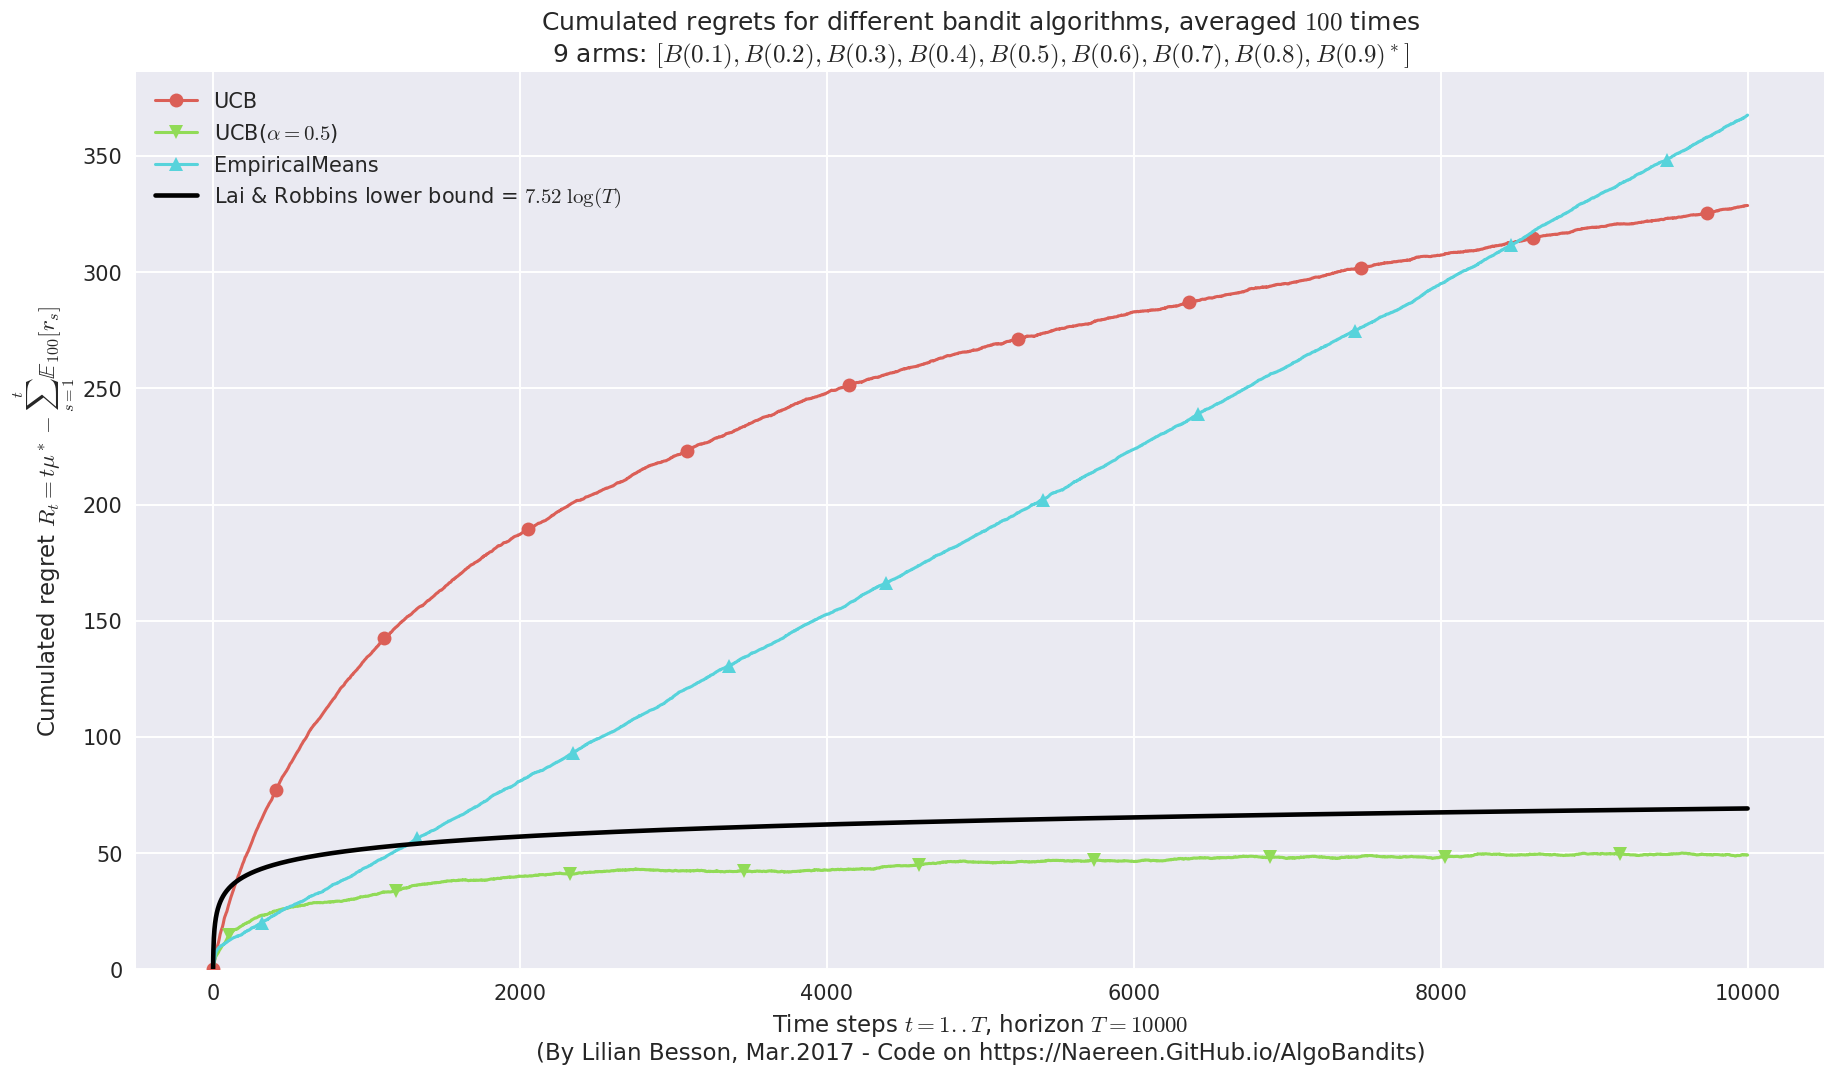


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...


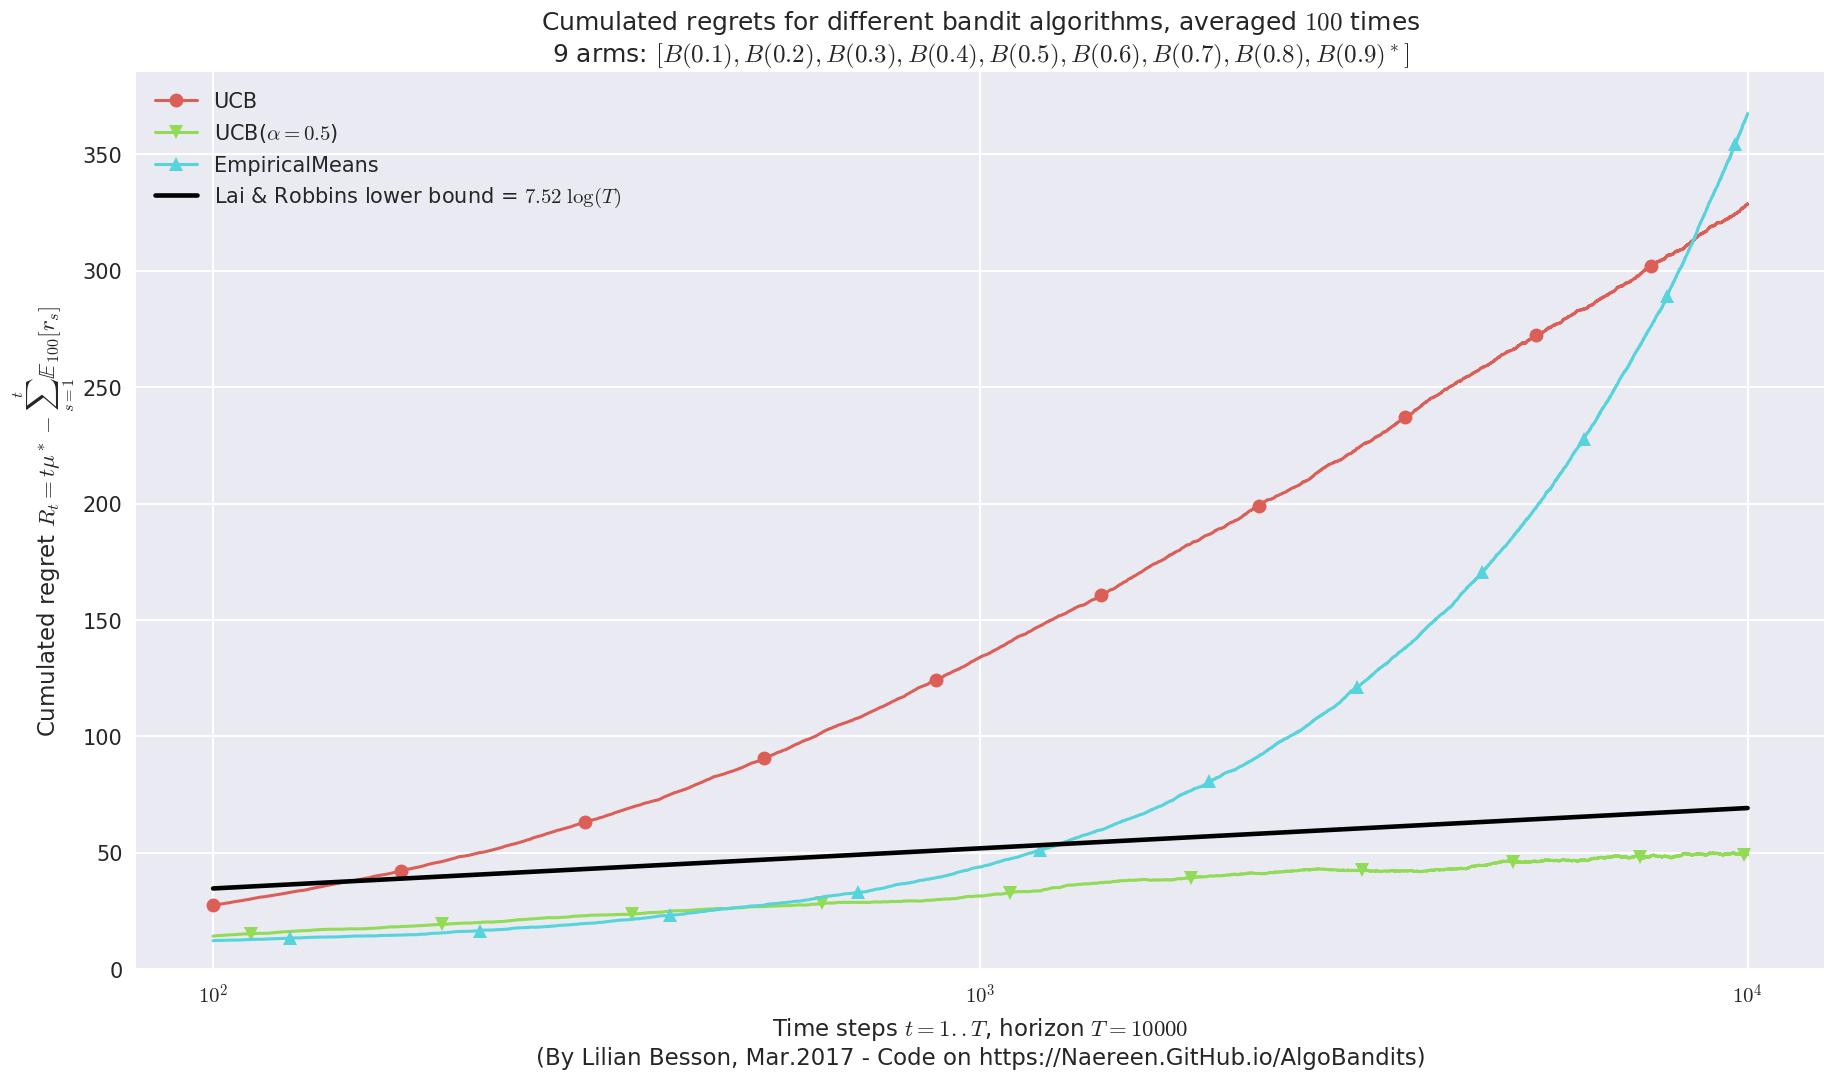


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...


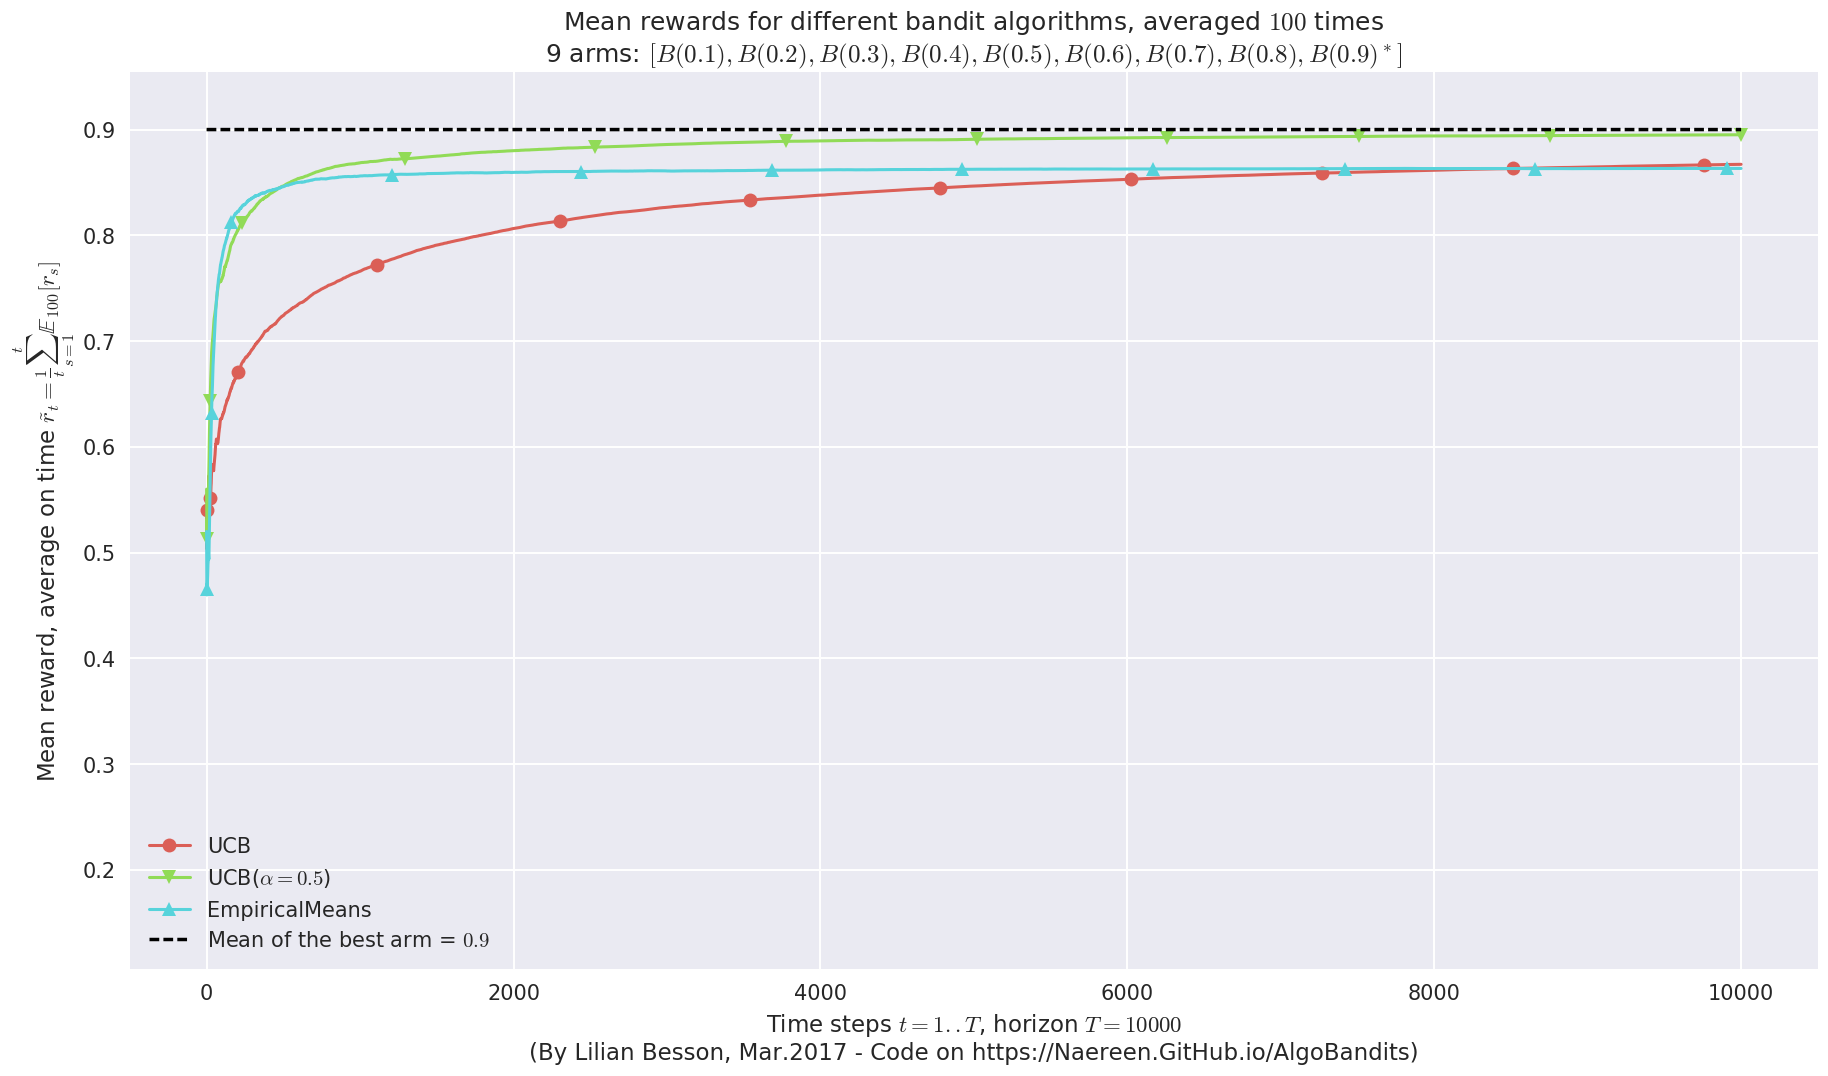

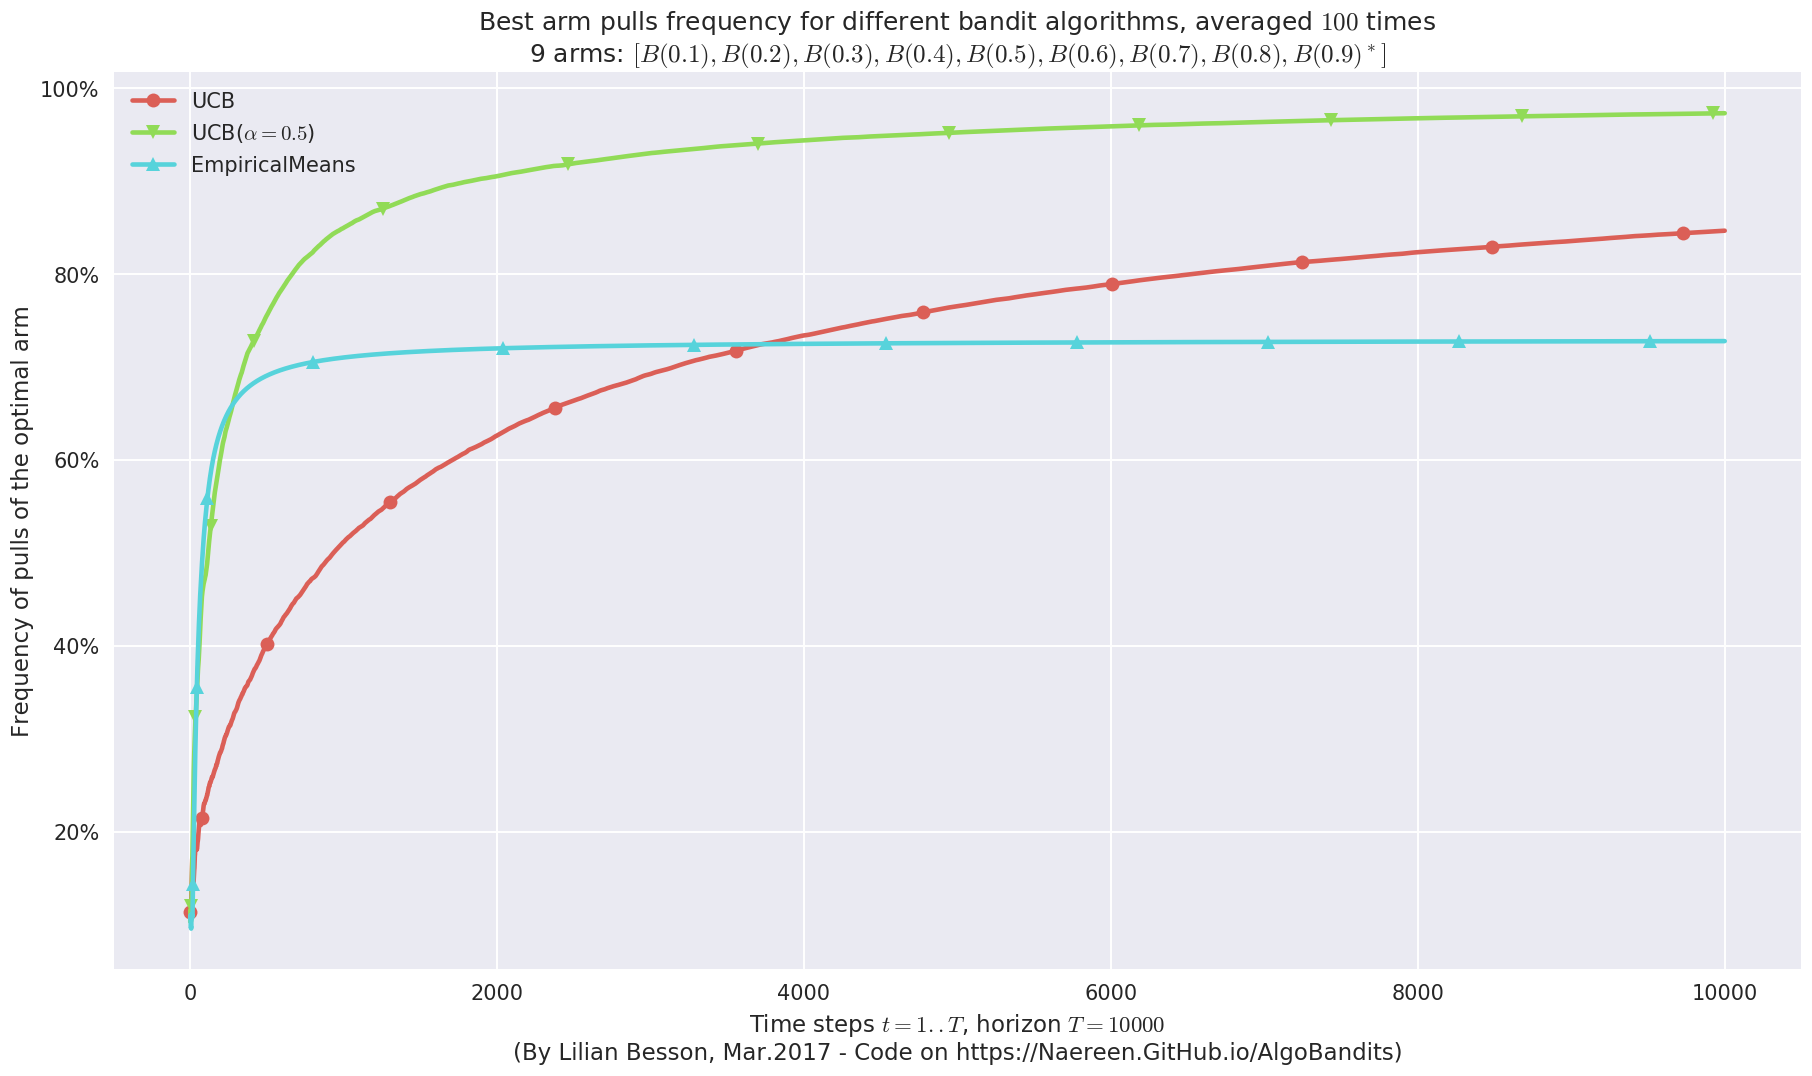

In [16]:
plotAll(evaluation, 0)

### Second problem

$\mu = [B(0.01), B(0.02), B(0.3), B(0.4), B(0.5), B(0.6), B(0.795), B(0.8), B(0.805)]$ is harder. There is $3$ good arms, very close in term of mean rewards.

We could think that `EmpiricalMeans` will perform even more poorly here, but in fact although $\mathrm{UCB}_{\alpha=1/2}$ is more efficient in term of best arm identification, `EmpiricalMeans` is better in term of rewards as it simply focussed on the best arms, without trying to differente between the best $3$ arms.


Final ranking for this environment #1 :
- Policy 'UCB($\alpha=0.5$)'	was ranked	1 / 3 for this simulation (last regret = 72.965).
- Policy 'EmpiricalMeans'	was ranked	2 / 3 for this simulation (last regret = 129.855).
- Policy 'UCB'	was ranked	3 / 3 for this simulation (last regret = 236.885).

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 101 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 55.39% ...


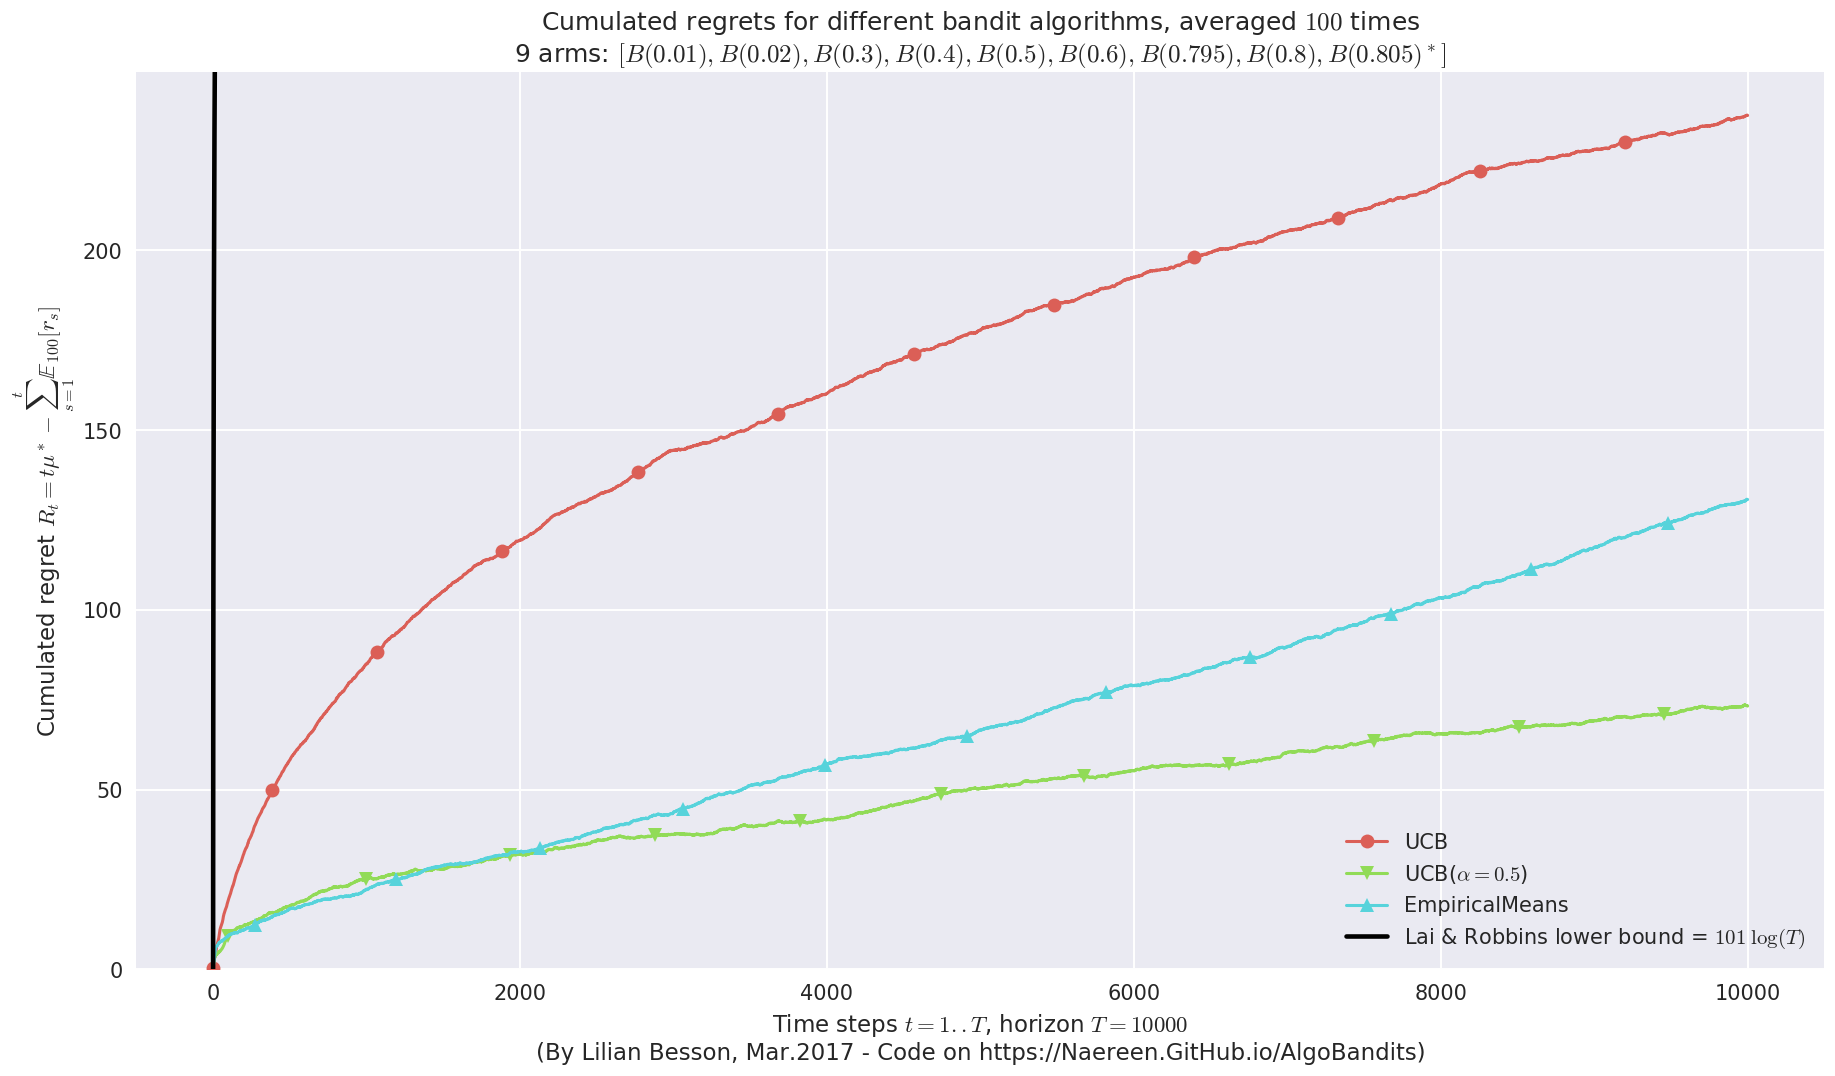


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 101 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 55.39% ...


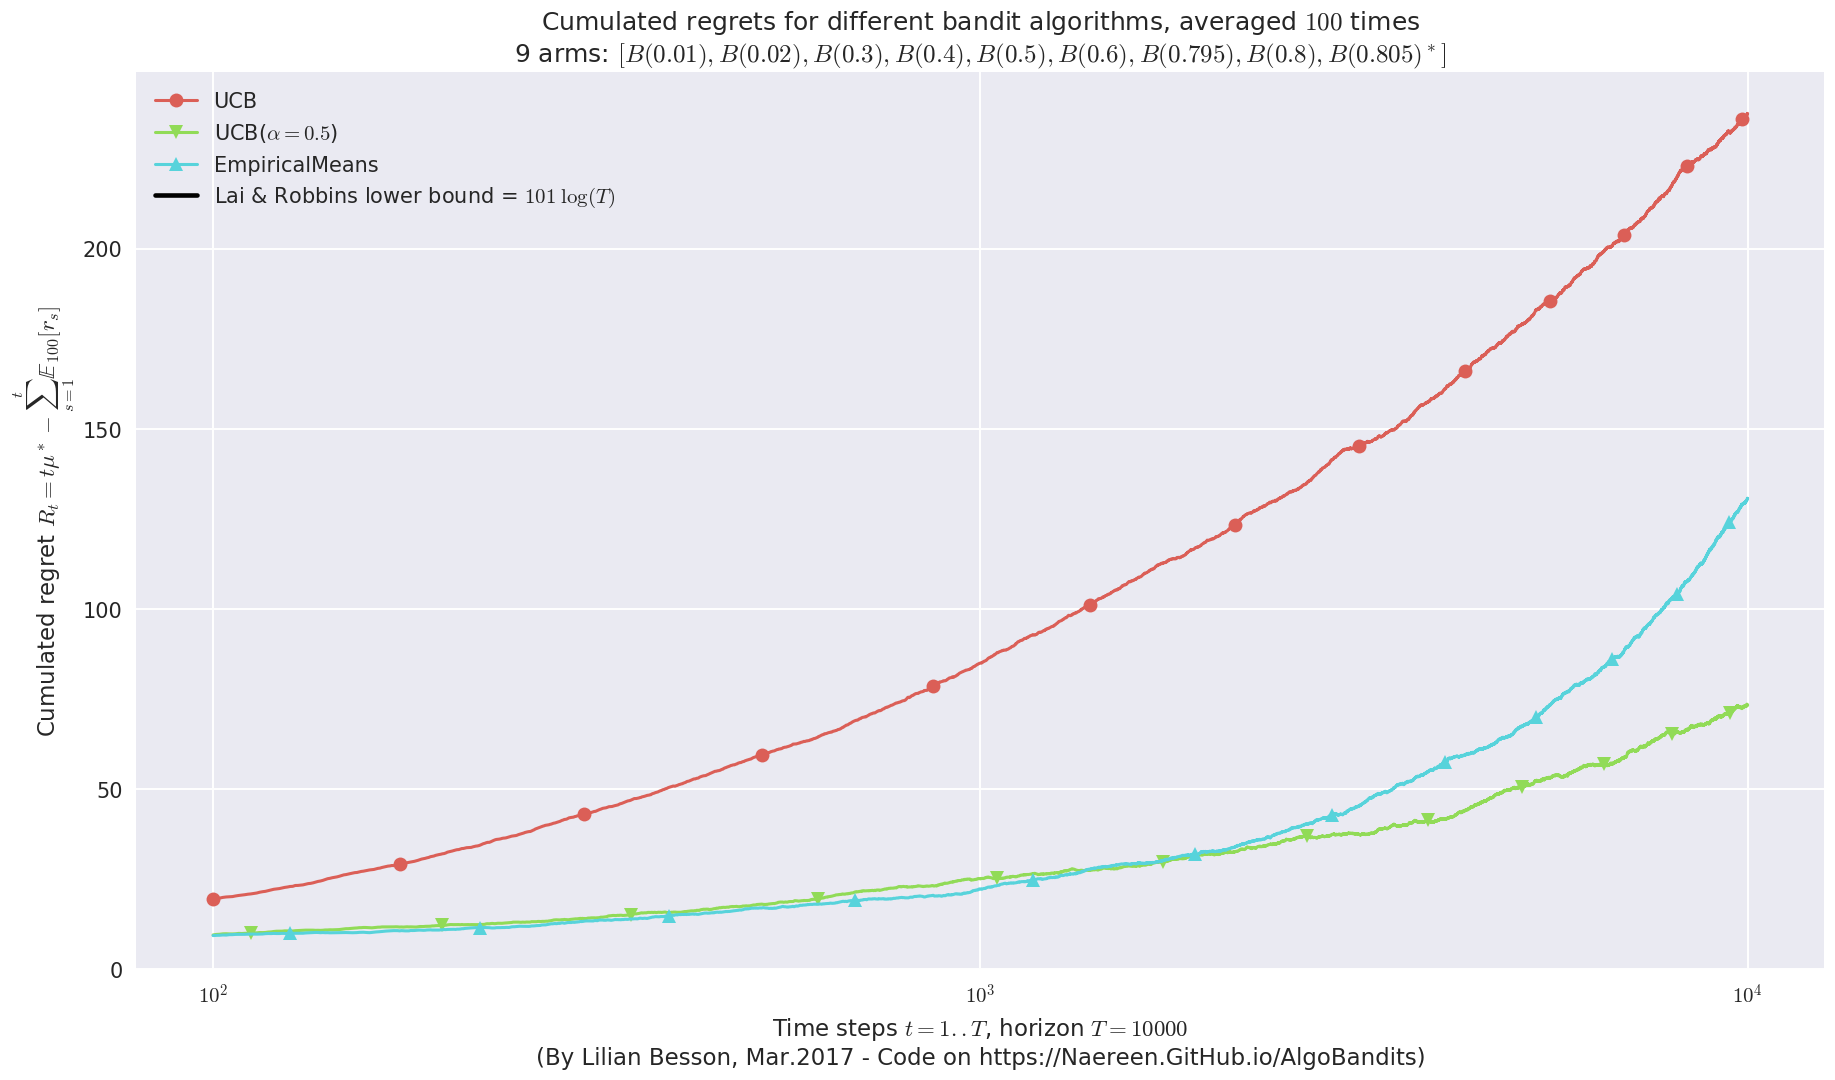


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 101 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 55.39% ...


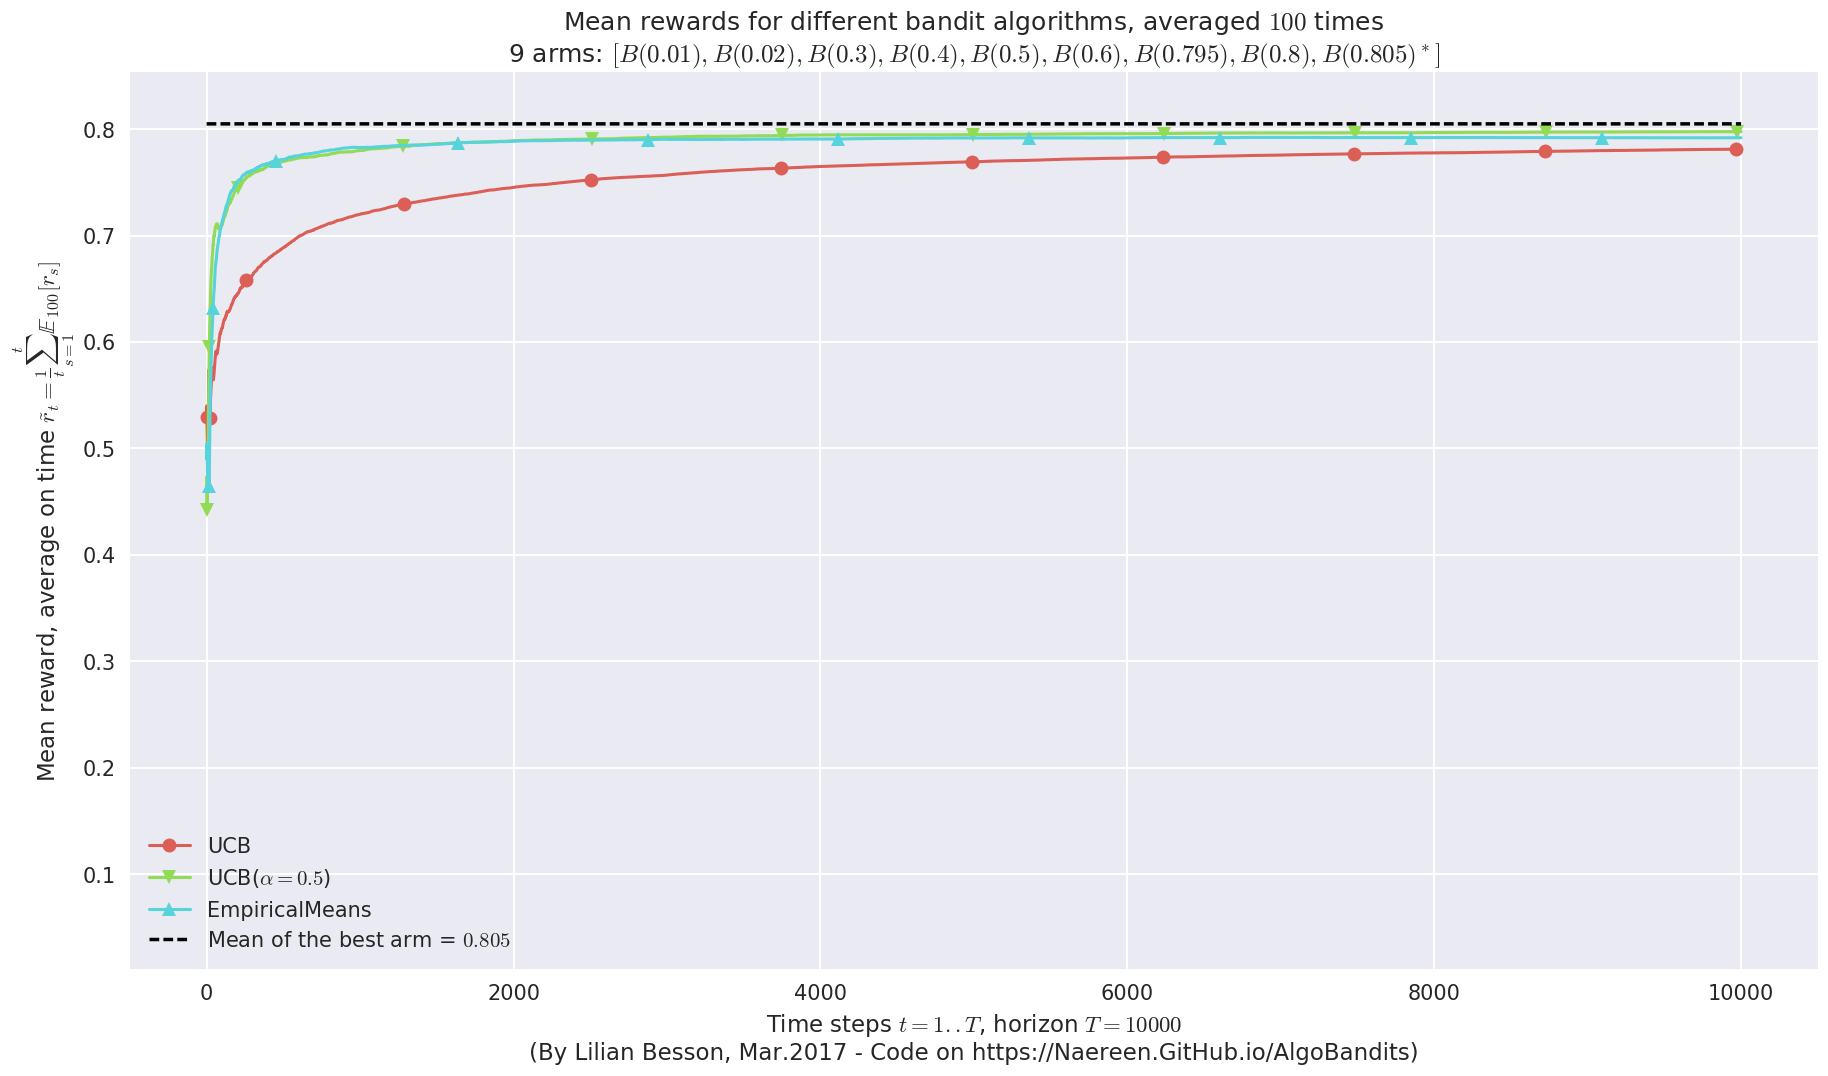

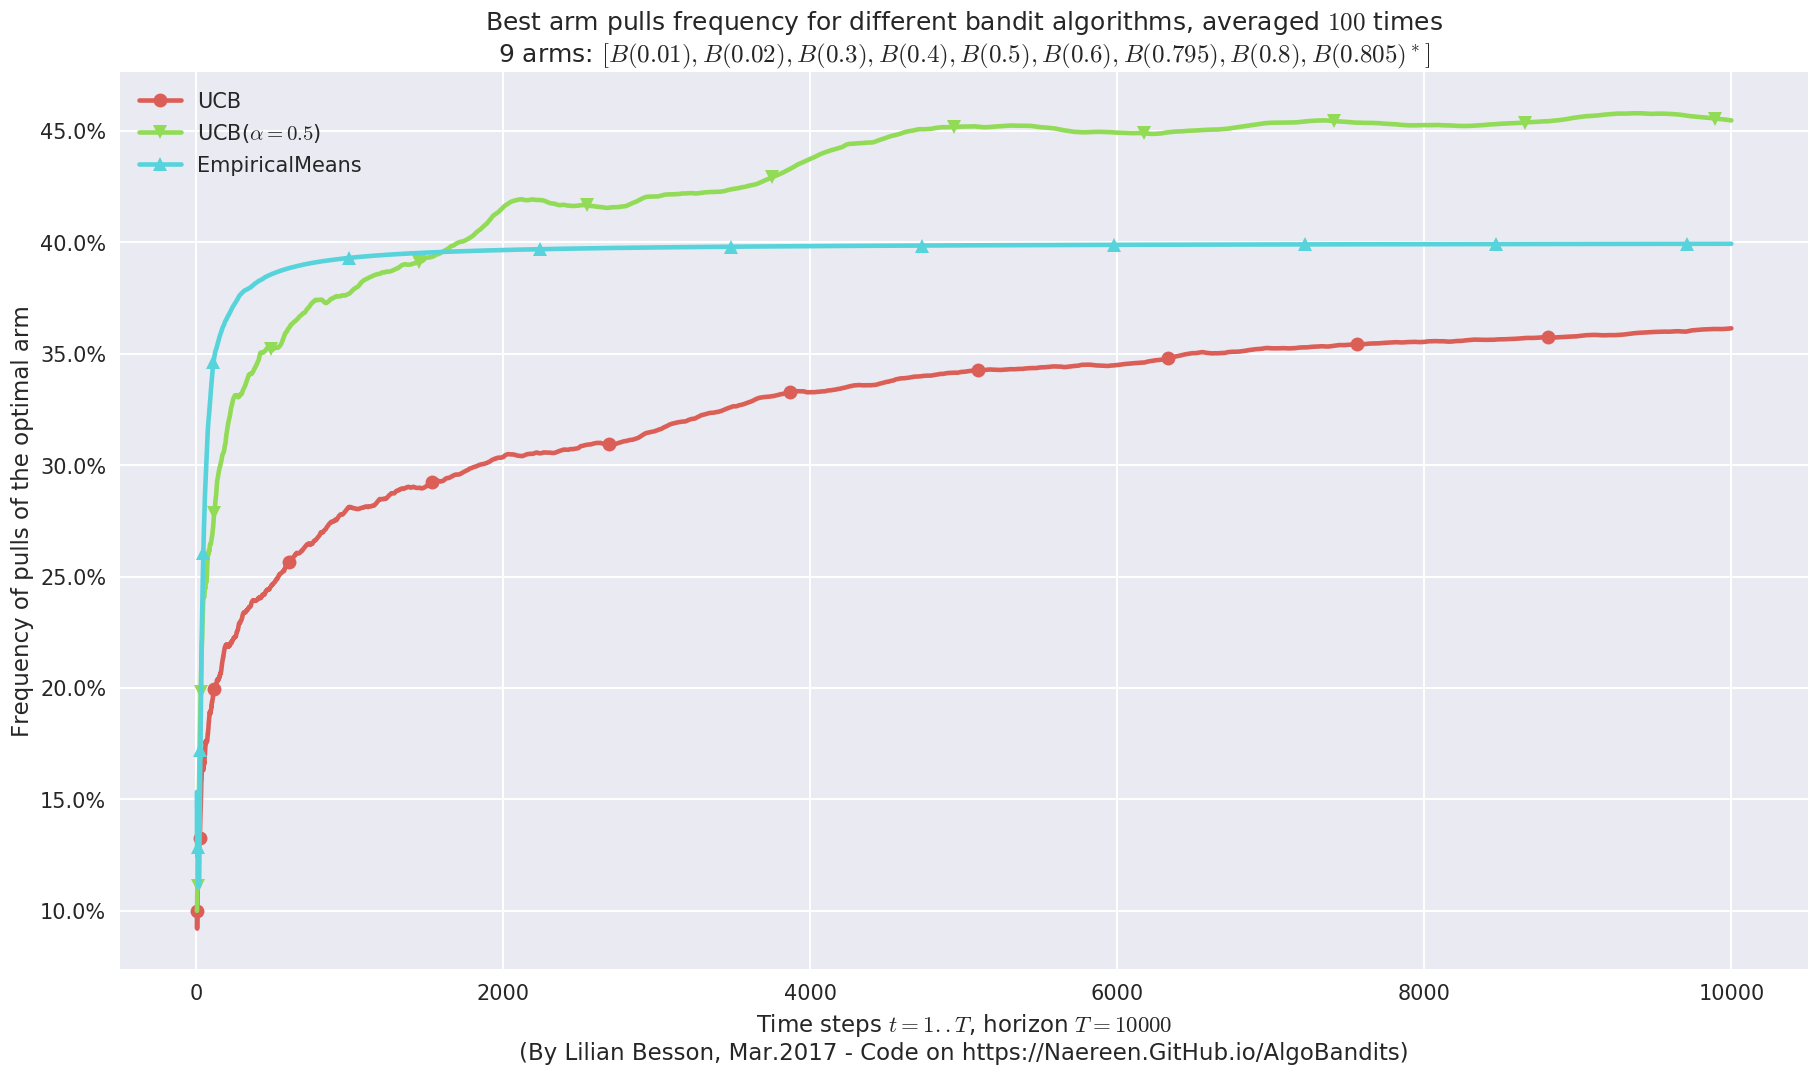

In [17]:
plotAll(evaluation, 1)

### Third problem

$\mu = [B(0.01), B(0.01), B(0.01), B(0.02), B(0.02), B(0.02), B(0.05), B(0.05), B(0.1)]$ is another "hard" problem.

This time, `EmpiricalMeans` is clearly worse than `UCBalpha`.


Final ranking for this environment #2 :
- Policy 'UCB($\alpha=0.5$)'	was ranked	1 / 3 for this simulation (last regret = 162.84).
- Policy 'EmpiricalMeans'	was ranked	2 / 3 for this simulation (last regret = 391.55).
- Policy 'UCB'	was ranked	3 / 3 for this simulation (last regret = 484.38).

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 14.5 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 82.11% ...


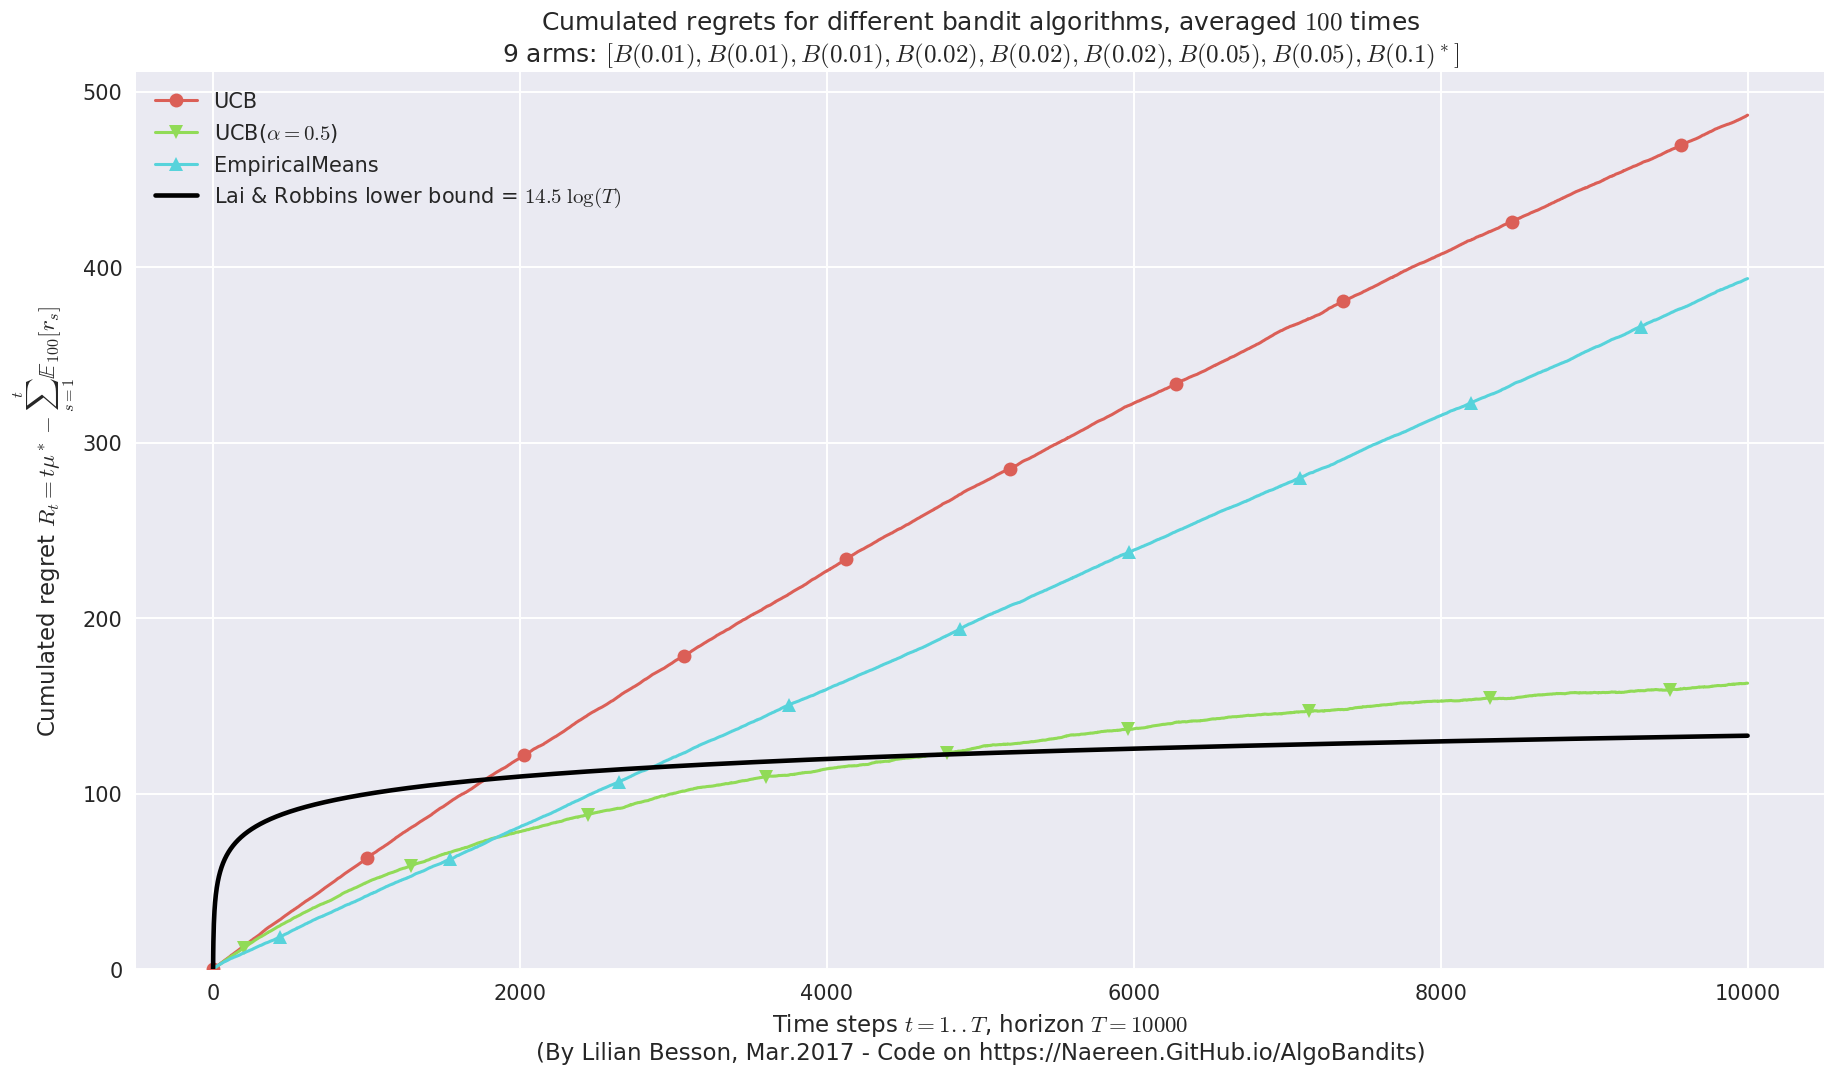


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 14.5 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 82.11% ...


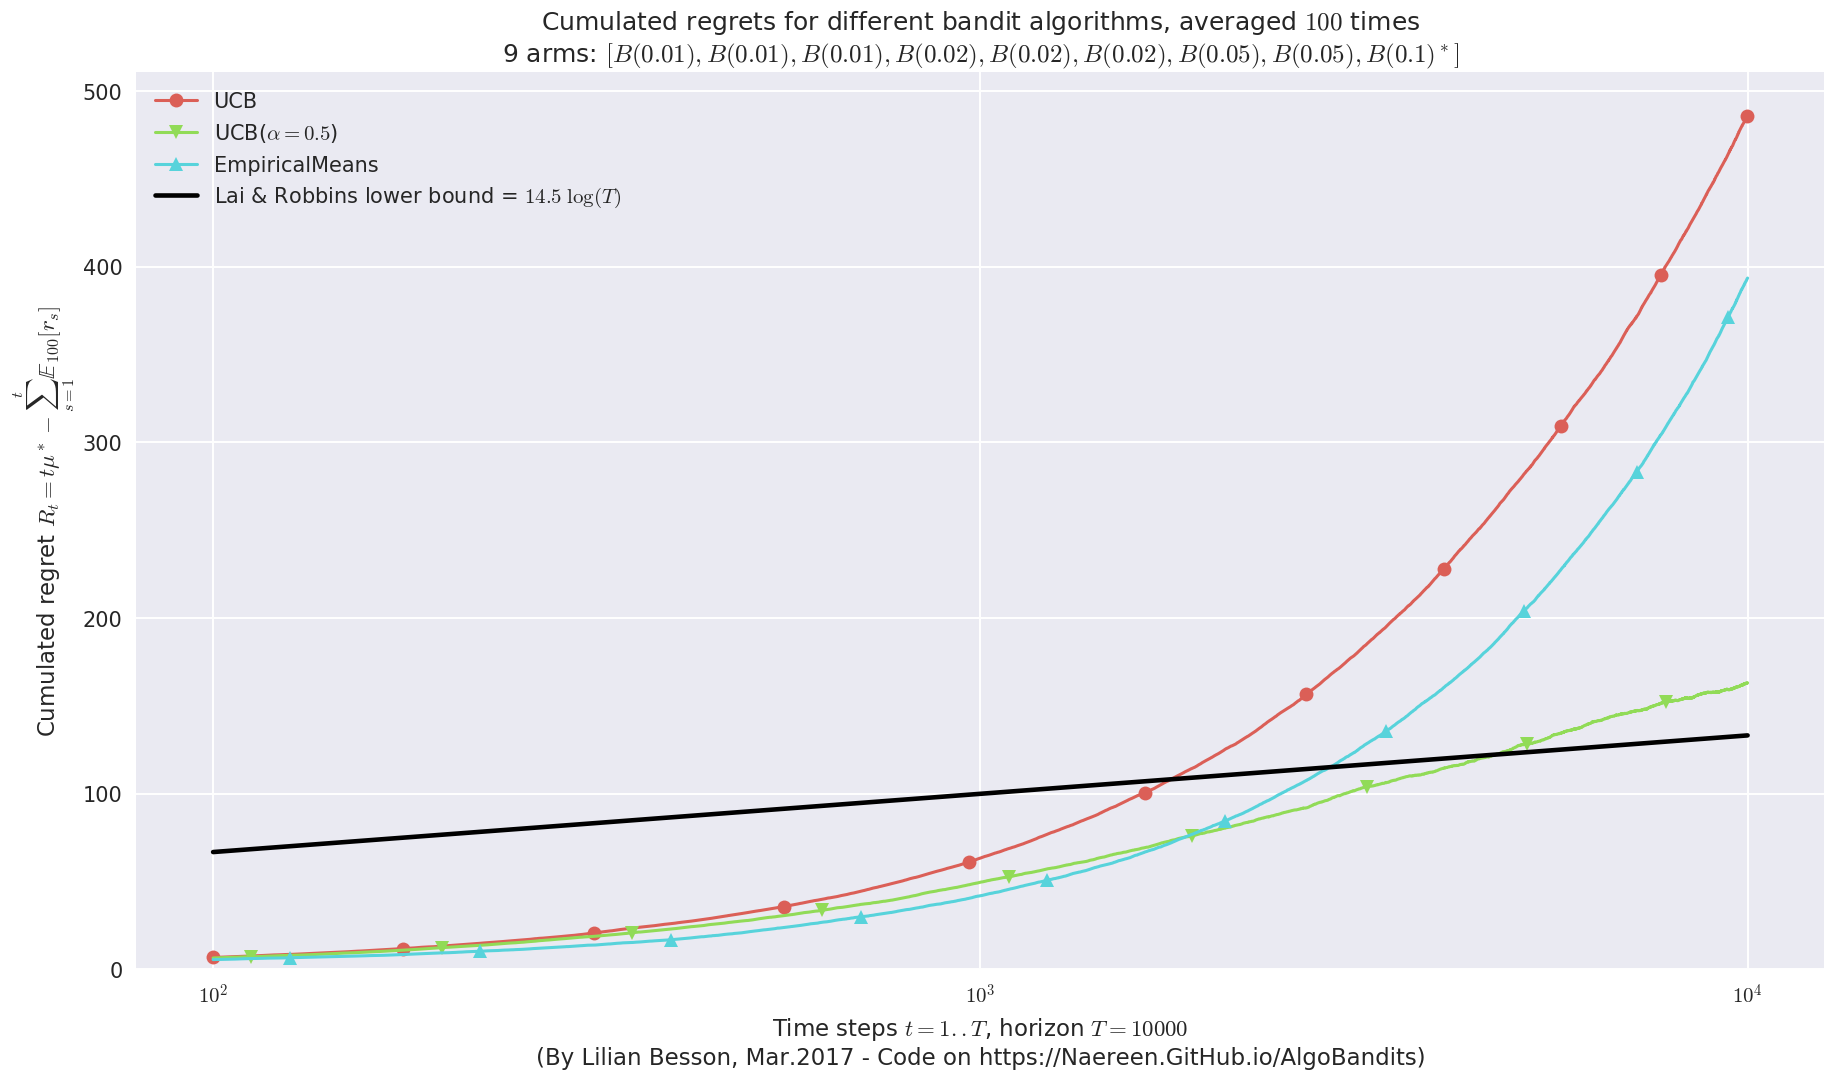


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 14.5 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 82.11% ...


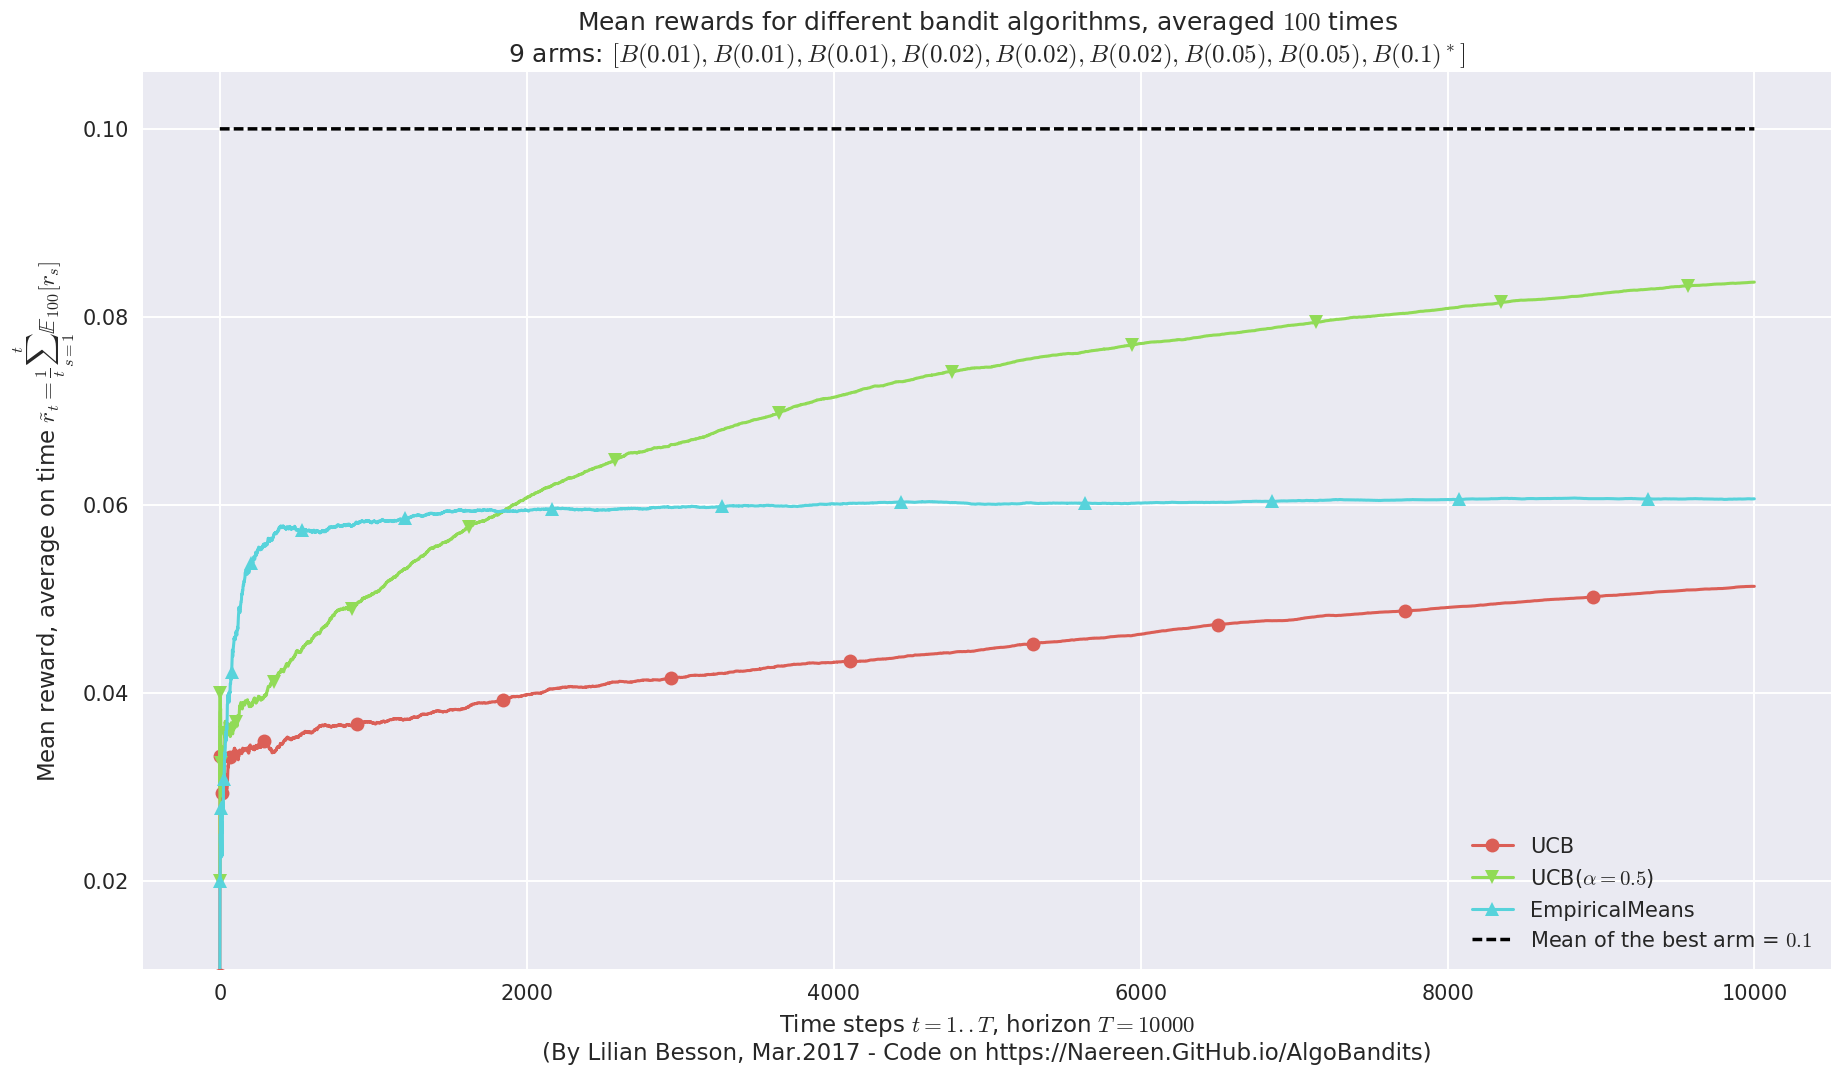

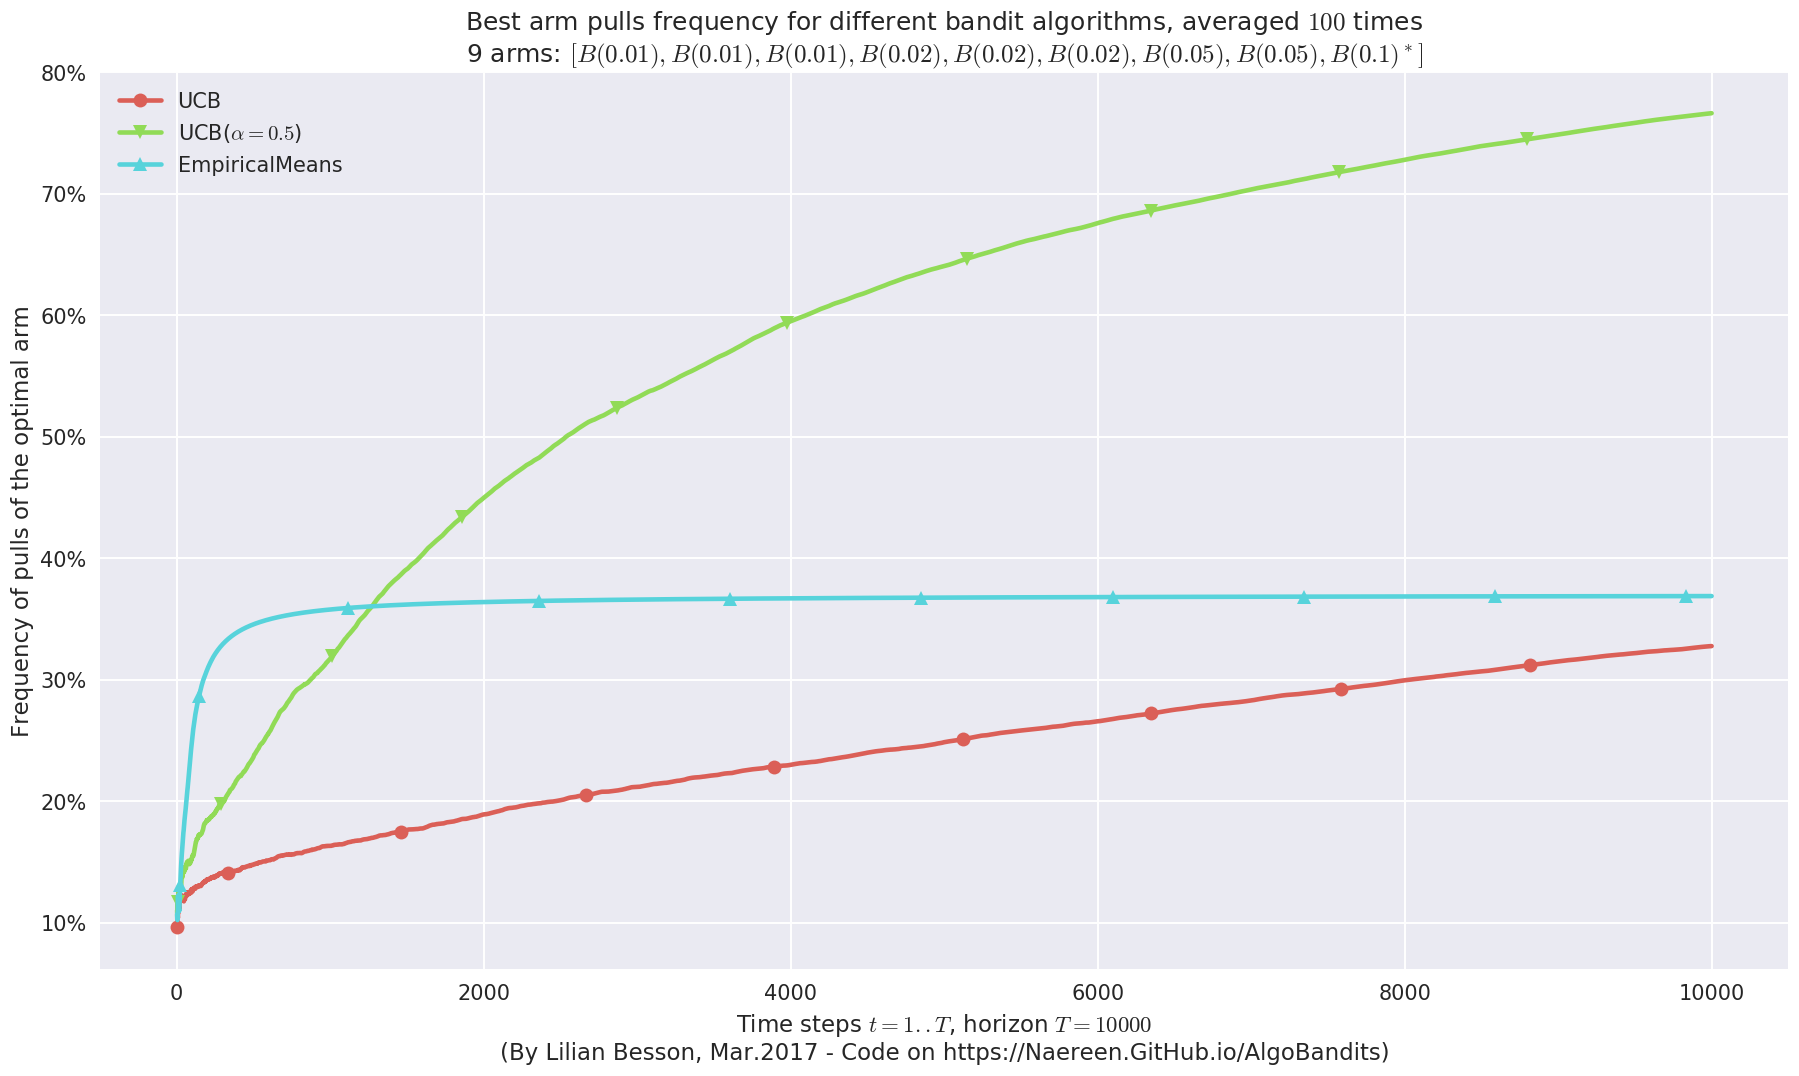

In [18]:
plotAll(evaluation, 2)

----
## Conclusion

This small notebook presented the Multi-Armed Bandit problem, as well as the well-known UCB policy, and a simpler policy just based on empirical means.

We illustrated and compared the performance of two UCB algorithms against `EmpiricalMeans`, on 3 different Bernoulli problems, and it appeared clearly that the confidence bound term in UCB is really useful, even for extremely simple Bernoulli problems.

---
> That's it for this demo!